This notebook provides an example of how to extract the data from the dataframes, refine and plot. The files can be downloaded and stored in data/raw folder. 

In [ ]:
import os, sys
sys.path.append(os.getcwd().replace('/notebooks',''))
import pandas as pd #dataframes etc
import numpy as np
from sklearn import preprocessing
from common.pltutils import getNcols, plt
import seaborn as sns

plt.style.use('../common/default.style')

Crystals from different $\eta$ regions, which receive different levels of radiation doses are selected for comparison.
The crystals with higher pseudorapidity values see more degradation in the trasparancies. The following dictionary contains
(ieta_ring_number, eta_ring, pseudorapidity) as keys and crystal IDs as their correponding values.

In [6]:
xtallist = {
    (1, 1, 0): 30600,
    (66, 14, 1.15112): 54000,
    (90, 19, 1.58292): 68622,
    (100, 21, 1.81802): 69193,
    (110, 24, 2.13646): 69977,
    (117, 26, 2.45199): 70606,
    (122, 28, 2.7795): 71163
}

eta_bins = [0.0, 1.5, 1.8, 2.1, 2.4, 2.7, 3.0, 5.0]

In [3]:
# get the laser values for crystals
laser_response = {}
for ring in xtallist:
    ieta_ring = ring[0]
    xtal = xtallist[ring]
    filename = '../data/raw/plus_z/ring_{}.csv'.format(ieta_ring)
    df = pd.read_csv(filename)
    laser_response[xtal] = (pd.to_datetime(df['laser_datetime'][df['xtal_id']==xtal]).to_numpy(), df['calibration'][df['xtal_id']==xtal].to_numpy())

In [4]:
cmap = getNcols(len(xtallist.keys()))

The figure shows the calibration values for 5 crystals from 5 different pseudorapidity regions in the CMS from 2016 through 2018. The gaps in between are Year End Technical Stops (YETSs), where the LHC halts its operation. During this time, the crystals "recover" and the calibration values are higher when the LHC resumes operation after the halt.

<Figure size 640x480 with 0 Axes>

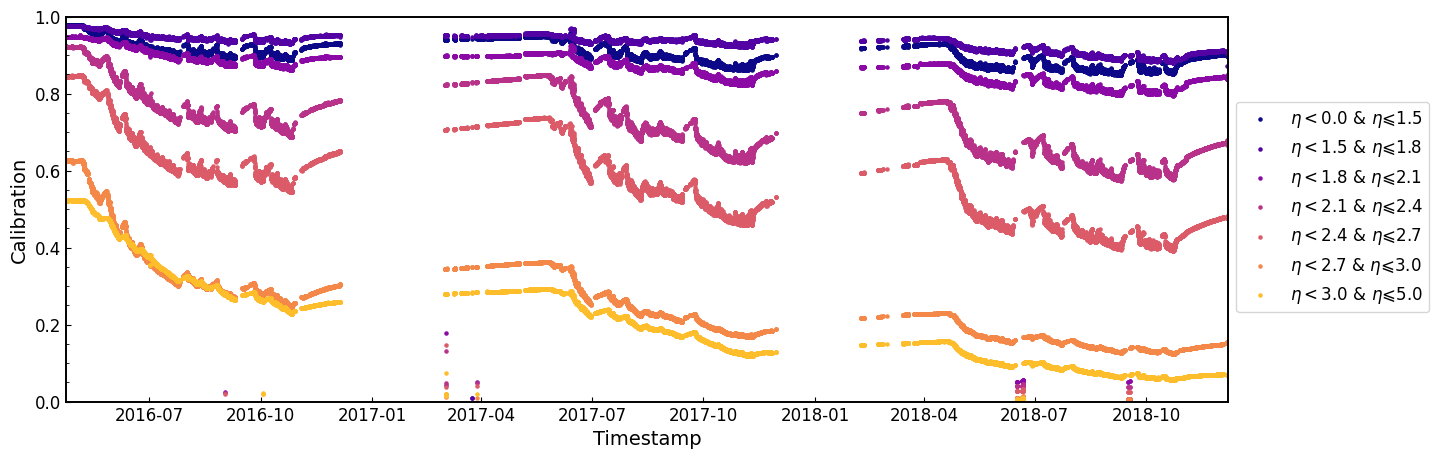

In [18]:
plt.clf()
plt.figure(figsize=(15, 5))
for ixtal, xtal in enumerate(laser_response):
    plt.scatter(laser_response[xtal][0], laser_response[xtal][1], color=cmap[ixtal],
                label='$\eta<%s\ &\ \eta\leqslant%s$' % (eta_bins[ixtal],eta_bins[ixtal+1]),
                s=5)
plt.ylabel('Calibration', fontsize=14)
plt.xlabel('Timestamp', fontsize=14)
plt.xlim(pd.to_datetime('2016-04-23 12:09:53'), pd.to_datetime('2018-12-07 12:00:00'))
plt.ylim(0.0, 1.0)
plt.legend(loc='upper right', fontsize=12, bbox_to_anchor=(1.18,0.8), ncol=1)
plt.show()

You'll notice that the laser response drops by a large value at certain times. This corresponds to the mis-measurements.
These can be removed by adding a condition which requires the absolute difference in any two consecutive value does not exceed a certain threshold.

For filtering the outliers, a moving average can be define with a window of 30 consecutive measurements. The relative change in the values with respect to the moving average can be calculated. In this way, it is easier to pick out outliers for the crystals at high and low calibration values alike.

In [8]:
dlr = {}
for xtal in laser_response.keys():
    minus_window = 15
    plus_window = 15
    total_window = (minus_window+plus_window)
    mean_lr = np.mean(laser_response[xtal][1])
    mvavg = np.append(np.ones(minus_window)*laser_response[xtal][1][0], laser_response[xtal][1])
    mvavg = np.append(mvavg, np.ones(plus_window)*laser_response[xtal][1][-1])
    mvavg = np.cumsum(mvavg, dtype=float)
    mvavg = (mvavg[total_window:]-mvavg[:-total_window])/total_window
    dlr[xtal] = (laser_response[xtal][1]-mvavg)/np.sqrt(mvavg)

An arbitrary cut of -0.03 is placed on the relative difference to remove th outliers.

<Figure size 640x480 with 0 Axes>

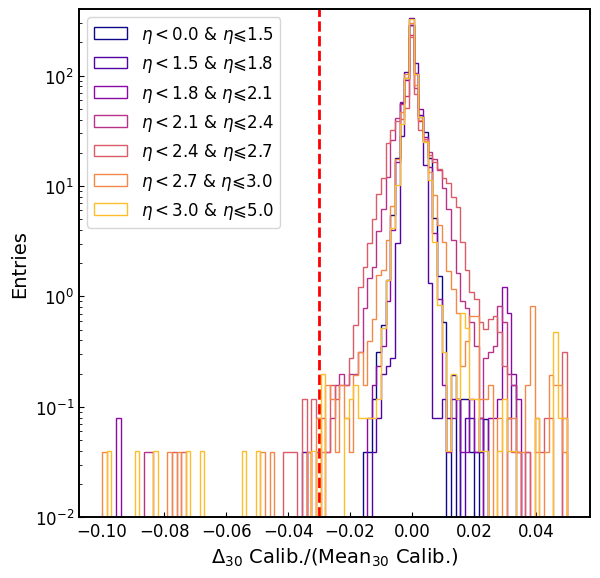

In [11]:
plt.clf()
plt.figure(figsize=(6.6, 6.6))
plt.plot((-.03, -.03),(.01, 400.0), linestyle='--', color='red', linewidth=2)
for ixtal, xtal in enumerate(laser_response):
    plt.hist(dlr[xtal], color=cmap[ixtal], histtype='step', density=True, bins=100, range=(-0.1,0.05),
             label='$\eta<%s\ &\ \eta\leqslant%s$' % (eta_bins[ixtal],eta_bins[ixtal+1]))
plt.xlabel('$\Delta_{30}$ Calib./(Mean$_{30}$ Calib.)', fontsize=14)
plt.ylabel('Entries', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.yscale('log')
plt.ylim(0.01, 400.0)
plt.show()

The dataset can then be trimmed based on the cut on the relative change in calibration values obtained from the above histogram. Furthermore, the time period between 2018-06-12 00:00:00 and 2018-06-22 23:59:59 has similar calibration values and even though these are clearly outliers, these point remain after the cut. Hence, any point appearing within this time period are removed by an additional cut.

In [12]:
trimmed_laser_response = {}
outliers = {}
for xtal in laser_response.keys():
    mask = (((laser_response[xtal][0]<np.datetime64('2018-06-12T00:00:00')) |
            (laser_response[xtal][0]>np.datetime64('2018-06-22T23:59:59'))) & (dlr[xtal]>-0.03))
    trimmed_laser_response[xtal] = (laser_response[xtal][0][mask], laser_response[xtal][1][mask])
    outliers[xtal] = (laser_response[xtal][0][~mask], laser_response[xtal][1][~mask])

The calibration values are now free of any outliers as can be seen from the following plots. These values can now be used to train LSTM models.

<Figure size 640x480 with 0 Axes>

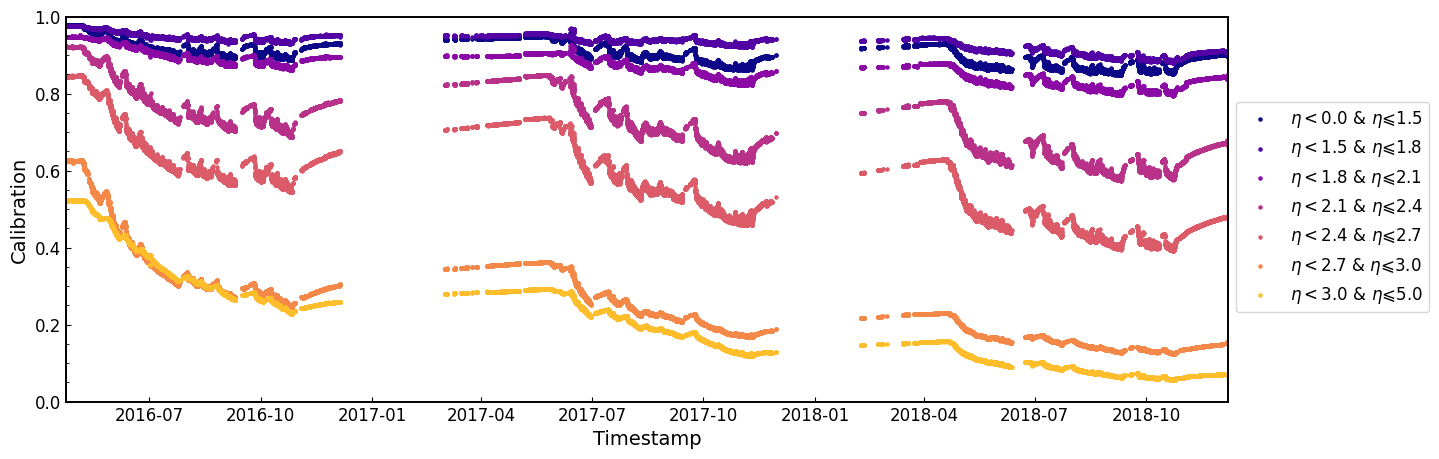

In [16]:
plt.clf()
plt.figure(figsize=(15, 5))
for ixtal, xtal in enumerate(laser_response):
    plt.scatter(trimmed_laser_response[xtal][0], trimmed_laser_response[xtal][1], color=cmap[ixtal],
                label='$\eta<%s\ &\ \eta\leqslant%s$' % (eta_bins[ixtal],eta_bins[ixtal+1]),
                s=5)
plt.ylabel('Calibration', fontsize=14)
plt.xlabel('Timestamp', fontsize=14)
plt.xlim(pd.to_datetime('2016-04-23 12:09:53'), pd.to_datetime('2018-12-07 12:00:00'))
plt.ylim(0.0, 1.0)
plt.legend(loc='upper right', fontsize=12, bbox_to_anchor=(1.18,0.8), ncol=1)
plt.show()

The following figure shows the calibration values that have been removed as ouitliers.

<Figure size 640x480 with 0 Axes>

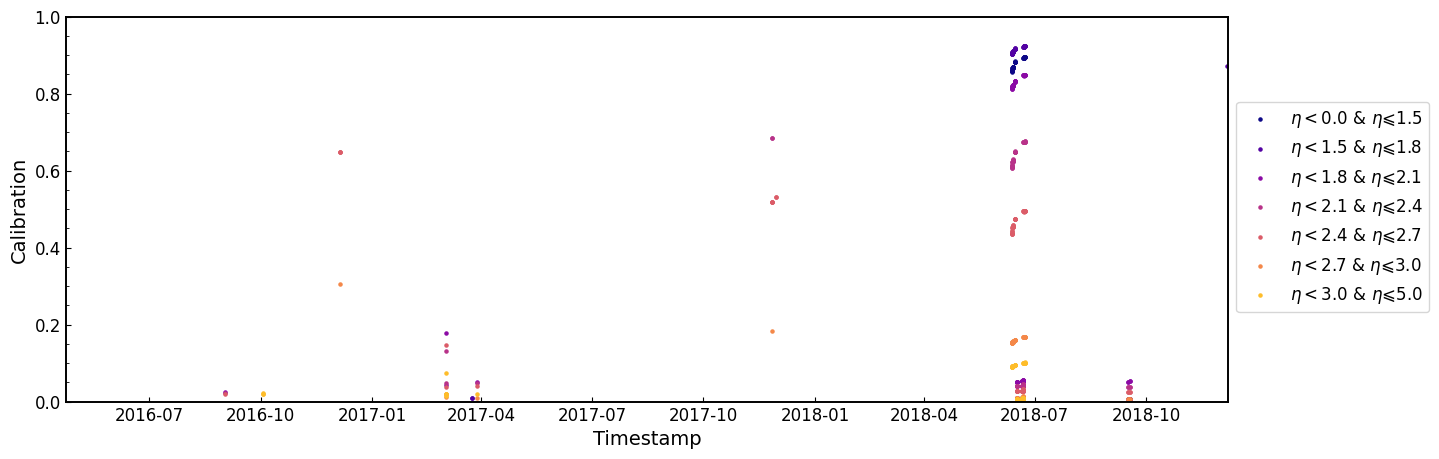

In [17]:
plt.clf()
plt.figure(figsize=(15, 5))
for ixtal, xtal in enumerate(laser_response):
    plt.scatter(outliers[xtal][0], outliers[xtal][1], color=cmap[ixtal],
                label='$\eta<%s\ &\ \eta\leqslant%s$' % (eta_bins[ixtal],eta_bins[ixtal+1]),
                s=5)
plt.ylabel('Calibration', fontsize=14)
plt.xlabel('Timestamp', fontsize=14)
plt.xlim(pd.to_datetime('2016-04-23 12:09:53'), pd.to_datetime('2018-12-07 12:00:00'))
plt.ylim(0.0, 1.0)
plt.legend(loc='upper right', fontsize=12, bbox_to_anchor=(1.18,0.8), ncol=1)
plt.show()